# Tutorial no. 5 - Dynamic circuits

[Youtube link](https://www.youtube.com/watch?v=QDPtcwhpQkE)

Dynamic circuit - classical measurements midway determine what quantum operations to perform next.

Dynamic circuit and static circuit - same computational power (can be represented with each over). Logically same - noise-wise different. Can trade depth with width of the circuit.

Error correction, **simulation**, machine learning...

Error correction - repeated *syndrome measurements* to detect errors. Dynamic better for preparing highly entangled systems (for example GHZ, teleportation etc.)

## Long range CNOT gate teleportation

Implementing CNOT between first and last qubit, with n-2 (0) qubits inbetween. Need many SWAP gates to interact through CNOT. We can simplify.

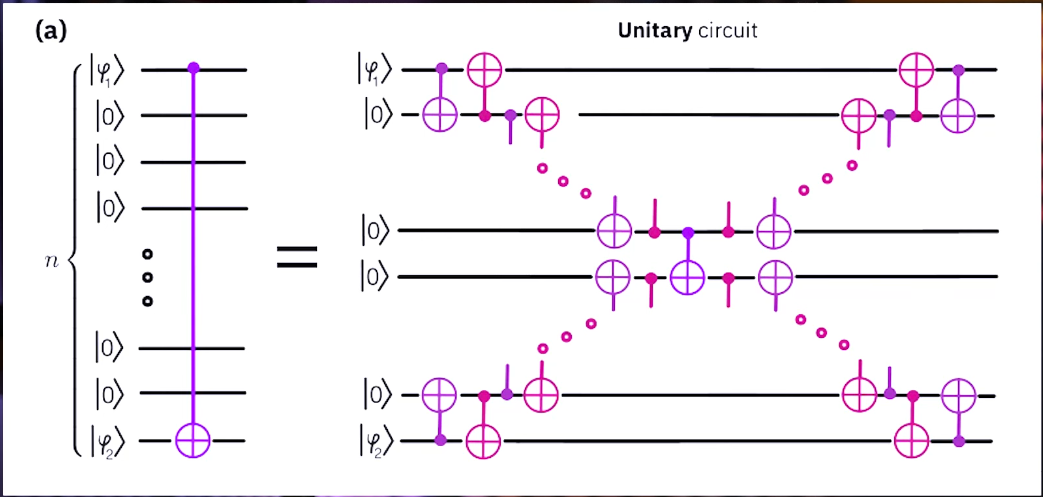

Still decoherence will win out.

But if we write dynamic circuit (2 qubit gate depth of 2 + some classical measurements and processing to teleport CNOT) - no problem.

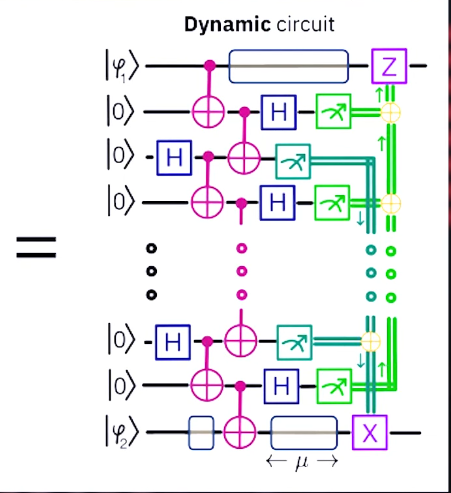

And we will now implement this dynamic circuit.

# Step 1: Map the problem to circuits and operators (observables)

In [5]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.classical import expr # midcircuit measurements, do classical logic

def get_dynamic_CNOT_circuit(num_qubits):
    # Assumptions:
    """
    (1) 1D chain of nearest neighbors
    (2) 0th qubit is the control, and last qubit (num_qubit-1) is the target
    (3) The control qubit starts in the + state
    """
    # (3) - Initialize the circuit so that when we apply CNOT gate, we have resulting Bell state 00+11. Use this to wuick test effectiveness of CNOT teleportation (rough metric of quality)
    
    num_ancilla = num_qubits - 2
    num_ancilla_pair = int(num_ancilla / 2)

    qr = QuantumRegister(num_qubits)
    cr1 = ClassicalRegister(num_ancilla_pair, name='cr1') # parity-controlled X gate
    cr2 = ClassicalRegister(num_ancilla - num_ancilla_pair, name='cr2') # parity-controlled Z gate
    cr3 = ClassicalRegister(2, name='cr3') # final measurements of control and target qubits
    qc = QuantumCircuit(qr, cr1, cr2, cr3)

    # Initialize the control qubit
    qc.h(0)
    qc.barrier()

    # Entanlge the control qubit and the first ancilla qubit
    qc.cx(0, 1)

    # Create Bell pairs on ancilla qubits
    # The first ancilla qubit in index 1
    for i in range(num_ancilla_pair):
        qc.h(2+2*i)
        qc.cx(2+2*i, 2+2*i+1)

    # Prepare Bell pairs on staggered ancilla and data qubits (Depth 2 CNOT part)
    for i in range(num_ancilla_pair+1):
        qc.cx(1+2*i, 1+2*i+1)
    for i in range(1, num_ancilla_pair+2):
        qc.h(2*i-1)
    
    # Measurement on alternating ancilla qubits starting with the first
    # Keep track of the parity for eventual conditional Z gate (Light green lines in the diagram)
    for i in range(1, num_ancilla_pair+2):
        qc.measure(2*i-1, cr2[i-1])
        if i == 1:
            parity_control = expr.lift(cr2[i-1]) # just take measured qubit and turn it into logical expression...
        else: 
            # Now compare new bit with previous bits
            parity_control = expr.bit_xor(cr2[i-1], parity_control)

    # Measurement on staggered alternating ancilla qubits starting with the second
    # Keep track of the parity of eventual conditional X gate   (Dark green lines in the diagram)
    for i in range(num_ancilla_pair):
        qc.measure(2+2*i, cr1[i])
        if i == 0:
            parity_target = expr.lift(cr1[i]) # just store value
        else:
            parity_target = expr.bit_xor(cr1[i], parity_target) # compare usin xor
    
    with qc.if_test(parity_control): #if 0, if 1...
        qc.z(0)
    
    with qc.if_test(parity_target):
        qc.x(-1)
    
    return qc


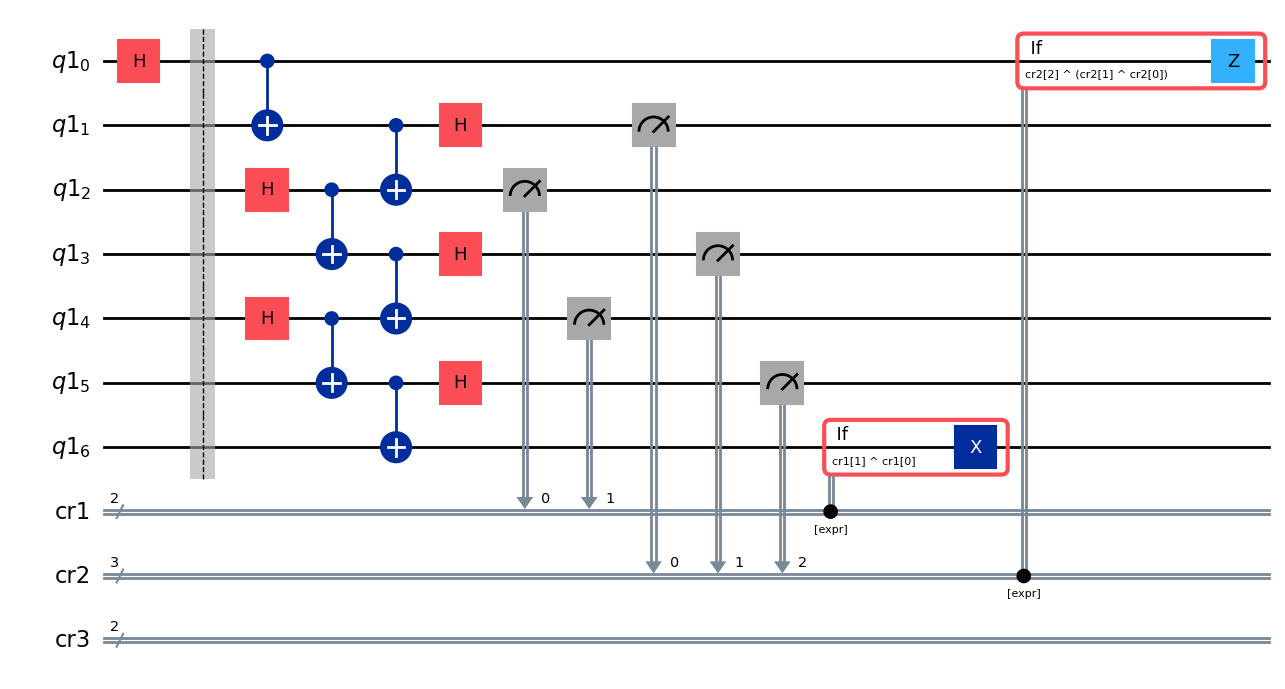

In [6]:
qc = get_dynamic_CNOT_circuit(num_qubits=7)
qc.draw('mpl')

Let's check quality of CNOT teleportation when increasing num of qubits...

> Wait, do I really know quantum teleportation? I should check that out again...

In [7]:
max_num_qubit = 41

qc_list = []
num_qubit_list = list(range(7, max_num_qubit+1, 2))
for num_qubit in num_qubit_list:
    qc_list.append(get_dynamic_CNOT_circuit(num_qubit))

# Step 2: Optimize the problem for quantum execution
> Later this gonna be the main part in the thesis paper, to use the optimization algorithms...

In [31]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import QiskitRuntimeService

backend_name = "ibm_brisbane"
service = QiskitRuntimeService()
backend = service.backend(backend_name)
pm = generate_preset_pass_manager(backend=backend, optimization_level=1)

qc_transpiled_list = pm.run(qc_list)

# Step 3: Execute the circuit

In [32]:
from qiskit_ibm_runtime import SamplerV2 as Sampler

sampler = Sampler(mode=backend)
job = sampler.run(qc_transpiled_list)
print(job.job_id())

cy2rtsk9b62g008h9f6g


# Step 4: Postprocessing and plotting

18 18


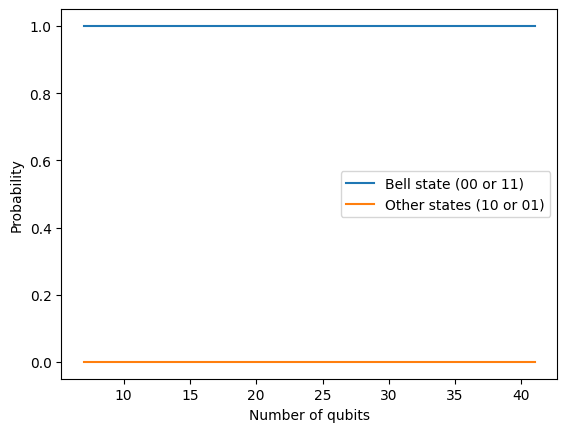

In [14]:
import matplotlib.pyplot as plt
from qiskit_ibm_runtime import QiskitRuntimeService

job_id = 'cy2rtsk9b62g008h9f6g'

service = QiskitRuntimeService()
job = service.job(job_id)
result = job.result()

print(len(result), len(qc_list))

list_Bell = [] # probabilities of 11 and 00
list_other = [] # probabilities of 01 and 10
for i in range(len(qc_list)):
    data = result[i].data
    counts = data.cr3.get_counts()
    total_counts = data.cr3.num_shots

    prob_Bell = (counts.get('00', 0) + counts.get('11', 0)) / total_counts
    
    list_Bell.append(prob_Bell)
    list_other.append(1 - prob_Bell)

plt.plot(num_qubit_list, list_Bell, label='Bell state (00 or 11)')
plt.plot(num_qubit_list, list_other, label='Other states (10 or 01)')
plt.xlabel('Number of qubits')
plt.ylabel('Probability')
plt.legend()

Hmm... for some reason there is no noise... Probs there are a lot of mistakes made here, but I guess whatever for now.

(There were problems with counts['11'] and results[] index out of bounds)